This is the second week's assignment which requires me to complete kernel methods about images' classifier and PCA using Power Iteration algorithm manually by myself.

In [4]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.feature_extraction import image
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from pylab import *

In [ ]:
# -*- coding: utf-8 -*-
# @Time    : 2018/1/21 12:43
# @Author  : Jiahao Yang
# @Email   : yangjh39@uw.edu

# ------------------------------ kernel methods about images' classifier ------------------------------ #
def fetch_patches(x, p=5):

    """
    Fetch small patches in each image and scale data

    :param x: (3d array) the set of image matrix from which patches are fetched
    :param p: the parameter of patches' size (pixels)
    :param n: the number of patches we will fetch in each image
    :return: the matrix of patches
    """
    patches_matrix = []

    for i in np.arange(x.shape[0]):
        patches = []

        m = image.extract_patches_2d(x[i], (p, p))

        for j in np.arange(m.shape[0]):
            patch = m[j].reshape(1, p**2)[0]

            if ((patch.__pow__(2).sum())**0.5) != 0:
                patch /= (patch.__pow__(2).sum())**0.5

            patches.append(patch.tolist())

        patches_matrix.append(patches)

    return np.array(patches_matrix)

def images_kernel(x, y, sigma=1):
    """
    Compute the Gaussian(RBF) kernel between X and Y for each pair of rows x in X and y in Y.

    :param x: matrix1
    :param y: matrix2
    :param sigma: hyper-parameter in Gaussian kernel
    :return: value of kernel
    """

    # Considering the rows of X, Y as vectors, compute the distance matrix between each pair of vectors.(sklearn)
    xx = np.einsum('ij,ij->i', x, x)[:, np.newaxis]
    yy = np.einsum('ij,ij->i', y, y)[np.newaxis, :]
    k = x.dot(y.T)
    k *= -2
    k += xx
    k += yy
    k = np.maximum(k, 0.)

    # Gaussian Kernel
    k /= -(sigma**2.)
    k = np.exp(k)

    return k.sum()

def model_training(traindata, kernelfunc=images_kernel, hyperpara=1):

    """
    Calculate inner product in training set for each class

    :param traindata: training data set
    :param kernelfunc: self-defined kernel function
    :param hyperpara: hyper-parameter in kernel function
    :return: the innerproduct in each class
    """

    trainmatrix = traindata[0]

    for i in np.arange(1, traindata.shape[0]):
        trainmatrix = np.concatenate((trainmatrix, traindata[i]))

    innerproduct = 0

    for j in np.arange(traindata.shape[0]):
        innerproduct += kernelfunc(trainmatrix, traindata[j], hyperpara)

    return innerproduct

def nearestMeanClassifier(traindata1, traindata2, testdata, trainingresult, kernelfunc=images_kernel, hyperpara=1):

    """
    Calculate and return the predict labels for test data

    :param traindata1: traindata labeled 1
    :param traindata2: traindata labeled -1
    :param testdata: test data set
    :param kernelfunc: self-defined kernel function
    :param trainingresult: the difference between two classes' inner product
    :param hyperpara: hyper-parameter in kernel function
    :return: predicted labels for test data
    """

    trainmatrix1 = traindata1[0]
    trainmatrix2 = traindata2[0]

    for i in np.arange(1, traindata1.shape[0]):
        trainmatrix1 = np.concatenate((trainmatrix1, traindata1[i]))

    for j in np.arange(1, traindata2.shape[0]):
        trainmatrix2 = np.concatenate((trainmatrix2, traindata2[j]))

    predict_labels = []

    for k in np.arange(testdata.shape[0]):
        testtrain1 = kernelfunc(trainmatrix1, testdata[k], hyperpara)
        testtrain2 = kernelfunc(trainmatrix2, testdata[k], hyperpara)

        predict_labels.append(np.sign(2*testtrain1 / traindata1.shape[0] - 2*testtrain2 / traindata2.shape[0] + trainingresult))

    return np.array(predict_labels)

if __name__ == '__main__':
    # Import data
    lfw = datasets.fetch_lfw_people(min_faces_per_person=30)

    # Record the shape of plot
    h, w = lfw.images.shape[1:3]

    # label with 1(Jean Chretien)
    lfw_class1 = lfw.images[np.where(lfw.target == 15)]
    # label with -1(Luiz Inacio Lula da Silva)
    lfw_class2 = lfw.images[np.where(lfw.target == 23)]

    n_samples1 = lfw_class1.shape[0]
    n_samples2 = lfw_class2.shape[0]

    # Generate train and test set and fetch the patches from them
    train_class1 = fetch_patches(lfw_class1[0:np.floor(n_samples1 * .75).__int__()])
    train_class2 = fetch_patches(lfw_class2[0:np.floor(n_samples2 * .75).__int__()])
    test_class1 = fetch_patches(lfw_class1[np.floor(n_samples1 * .75).__int__():n_samples1])
    test_class2 = fetch_patches(lfw_class2[np.floor(n_samples2 * .75).__int__():n_samples2])

    parameter = np.arange(0.1, 0.6, 0.05)

    error_rate = []

    for i in np.arange(len(parameter)):
        trainingresult = -model_training(train_class1, images_kernel, parameter[i])/(train_class1.shape[0]**2) + model_training(train_class2, images_kernel, parameter[i])/(train_class2.shape[0]**2)
        predlabel1 = nearestMeanClassifier(train_class1, train_class2, test_class1, trainingresult, images_kernel, parameter[i])
        predlabel2 = nearestMeanClassifier(train_class1, train_class2, test_class2, trainingresult, images_kernel, parameter[i])

        error_rate.append((sum(predlabel1 == -1) + sum(predlabel2 == 1)) / (len(predlabel1) + len(predlabel2)))

        pd.DataFrame(error_rate).to_csv("errorrate.csv")

        print("predlabel1 is : " + str(predlabel1))
        print("predlabel2 is : " + str(predlabel2))
        print("Misclassification Error is : " + str(error_rate[-1]))
        print(str(len(parameter) - i - 1) + " iteration left")

    plt.figure(1)
    plt.plot(parameter, error_rate, 'ro-')
    plt.xlabel('hyper-parameter sigma')
    plt.ylabel('misclassification error')
    plt.title('Misclassfication error using Gaussian kernel')
    plt.savefig('E:\\U Washington\\Study\\538\\HW\\hw3\\Python\\gaussian.png')


![title](exercise1_1.png)

In [ ]:
    # Calculate the distance between picture and the emperical mean in one class
    DavidB = lfw.images[np.where(lfw.target == 6)]
    lfw_onepeople = fetch_patches(DavidB)

    lfwmatrix = lfw_onepeople[0]
    for m in np.arange(1, lfw_onepeople.shape[0]):
        lfwmatrix = np.concatenate((lfwmatrix, lfw_onepeople[m]))

    distance = []

    for k in np.arange(len(parameter)):
        dist = []
        dist0 = 0

        for j in np.arange(lfw_onepeople.shape[0]):
            dist0 += images_kernel(lfwmatrix, lfw_onepeople[j], parameter[k])

        for m in np.arange(lfw_onepeople.shape[0]):
            dist1 = images_kernel(lfw_onepeople[m], lfw_onepeople[m], parameter[k]) + dist0/(lfw_onepeople.shape[0]**2)
            dist1 -= images_kernel(lfwmatrix, lfw_onepeople[m], parameter[k])*2/lfw_onepeople.shape[0]
            dist.append((dist1, m))

        print(k)

        distance.append(dist)

    # Draw a picture to show the order changing
    distance_matrix = pd.read_csv('ordermatrix.csv').iloc[:, 1::]

    for i in np.arange(distance_matrix.shape[0]):
        plotdat = pd.DataFrame({'dist': [float(x.split(', ')[0][1::]) for x in distance_matrix.iloc[0, :].tolist()], 'num': [int(x.split(', ')[1][0:-1]) for x in distance_matrix.iloc[0, :].tolist()]})
        plotdat = plotdat.sort_values('dist')

        plot(np.arange(1, distance_matrix.shape[1]+1, 1), plotdat['num']+i)

    xlabel('picture numbers')
    ylabel('ranks')
    title('Rank plot for 10 different sigmas')
    grid(True)

![title](exercise1_2.png)

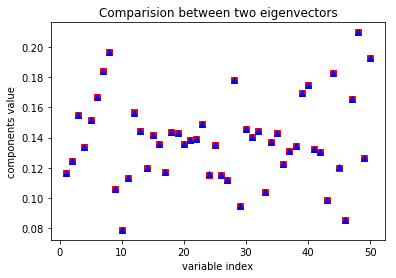

In [7]:
# ------------------------------ Performing PCA Using Power Iteration ------------------------------ #
# a) Generate a simulated data set
np.random.seed(9001)

data = pd.DataFrame(np.random.normal(0, 1, size=(20, 50)))
data = data.append(pd.DataFrame(np.random.normal(1, 1.25, size=(20, 50))))
data = data.append(pd.DataFrame(np.random.normal(2, 1.5, size=(20, 50))))
data.index = np.arange(60)
data['label'] = np.repeat(1, 20).tolist() + np.repeat(2, 20).tolist() + np.repeat(3, 20).tolist()

# b) Perform PCA
# Center data to have mean 0
data_centered = pd.DataFrame(scale(data.loc[:, np.arange(50)], with_mean=True, with_std=False))

# Power Iteration Algorithm
def power_iteration(A):
    n, d = A.shape

    v = np.ones(d) / np.sqrt(d)
    ev = v.dot(A.dot(v))

    while True:
        Av = A.dot(v)
        v_new = Av / np.linalg.norm(Av)

        ev_new = v_new.dot(A.dot(v_new))
        if np.abs(ev - ev_new) < 0.01:
            break

        v = v_new
        ev = ev_new

    return ev_new, v_new

eigen_value1, eigen_vector1 = power_iteration(data_centered.T.dot(data_centered))
eigen_vector1 = pd.DataFrame(eigen_vector1, columns=['c1'])

# Using sklearn's pca function
pca = PCA(n_components=1)
model = pca.fit(data_centered)
component1 = pd.DataFrame(model.components_[0],columns=['c1'])
value1 = model.explained_variance_[0]

# Comparision between the results of two methods
sse = (component1 - eigen_vector1).pow(2).sum()

plt.plot(np.arange(1, component1.shape[0]+1, 1), component1, 'rs', np.arange(1, eigen_vector1.shape[0]+1, 1), eigen_vector1, 'b^')
xlabel('variable index')
ylabel('components value')
title('Comparision between two eigenvectors')
plt.show()

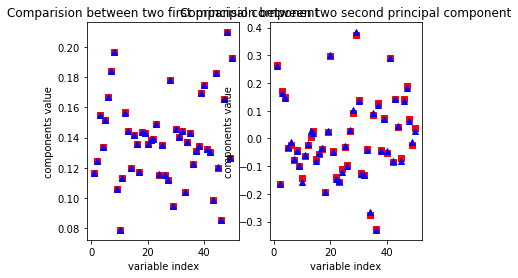

In [8]:

# c) Compute k principle components
def k_principle_cal(X, k=1):
    """
    Calculate the first k principal components based on power iteration algorithm

    :param X: sample matrix
    :param k: the number of principal components
    :return: the first k principal components and their eigenvalues respectively
    """

    initial_component = pd.DataFrame(np.zeros(X.shape[1]))

    eigen_value = []
    eigen_vector = []

    for i in np.arange(k):
        Xnew = X - (X.dot(initial_component)).dot(initial_component.T)
        eva, eve = power_iteration(Xnew.T.dot(Xnew))

        eigen_value.append(eva)
        eigen_vector.append(eve.tolist())

        initial_component = pd.DataFrame(eve).copy()

    return eigen_value, pd.DataFrame(eigen_vector).T

eigen_value, eigen_vector = k_principle_cal(data_centered, 2)
eigen_vector.iloc[:, 1] = -eigen_vector.iloc[:, 1]

# Using sklearn's pca function
pca = PCA(n_components=2)
model = pca.fit(data_centered)
component = pd.DataFrame(model.components_).T
value = model.explained_variance_

sse_all = (eigen_vector - component).pow(2).sum()

plt.subplot(121)
plt.plot(np.arange(1, component.shape[0]+1, 1), component.iloc[: ,0], 'rs', np.arange(1, eigen_vector.shape[0]+1, 1), eigen_vector.iloc[:, 0], 'b^')
xlabel('variable index')
ylabel('components value')
title('Comparision between two first principal component')

plt.subplot(122)
plt.plot(np.arange(1, component.shape[0]+1, 1), component.iloc[:, 1], 'rs', np.arange(1, eigen_vector.shape[0]+1, 1), eigen_vector.iloc[:, 1], 'b^')
xlabel('variable index')
ylabel('components value')
title('Comparision between two second principal component')
plt.show()

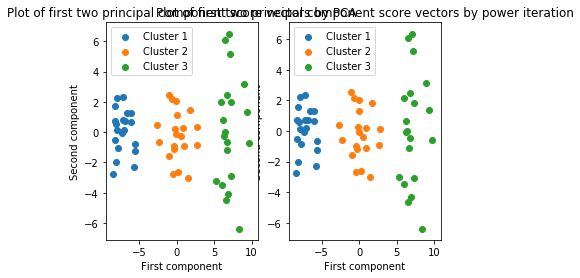

In [10]:
# Plot of first two principal component score vectors by PCA
pcafirst2component = pd.DataFrame(pca.fit_transform(data_centered), columns=['c1', 'c2'])
pcafirst2component['label'] = data['label']

plt.subplot(121)
pcadot1 = plt.scatter(pcafirst2component.loc[np.where(pcafirst2component['label'] == 1)[0].tolist(), 'c1'], pcafirst2component.loc[np.where(pcafirst2component['label'] == 1)[0].tolist(), 'c2'])
pcadot2 = plt.scatter(pcafirst2component.loc[np.where(pcafirst2component['label'] == 2)[0].tolist(), 'c1'], pcafirst2component.loc[np.where(pcafirst2component['label'] == 2)[0].tolist(), 'c2'])
pcadot3 = plt.scatter(pcafirst2component.loc[np.where(pcafirst2component['label'] == 3)[0].tolist(), 'c1'], pcafirst2component.loc[np.where(pcafirst2component['label'] == 3)[0].tolist(), 'c2'])

plt.xlabel('First component')
plt.ylabel('Second component')
plt.legend([pcadot1, pcadot2, pcadot3], ["Cluster 1", "Cluster 2", "Cluster 3"])
plt.title('Plot of first two principal component score vectors by PCA')
plt.show()

# Plot of first two principal component score vectors by power iteration
pifirst2component = data_centered.dot(eigen_vector)
pifirst2component['label'] = data['label']

plt.subplot(122)
dot1 = plt.scatter(pifirst2component.loc[np.where(pifirst2component['label'] == 1)[0].tolist(), 0], pifirst2component.loc[np.where(pifirst2component['label'] == 1)[0].tolist(), 1])
dot2 = plt.scatter(pifirst2component.loc[np.where(pifirst2component['label'] == 2)[0].tolist(), 0], pifirst2component.loc[np.where(pifirst2component['label'] == 2)[0].tolist(), 1])
dot3 = plt.scatter(pifirst2component.loc[np.where(pifirst2component['label'] == 3)[0].tolist(), 0], pifirst2component.loc[np.where(pifirst2component['label'] == 3)[0].tolist(), 1])

plt.xlabel('First component')
plt.ylabel('Second component')
plt.legend([dot1, dot2, dot3], ["Cluster 1", "Cluster 2", "Cluster 3"])
plt.title('Plot of first two principal component score vectors by power iteration')